In [29]:
from wikidata.client import Client
import json
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd

When asked to load a df from pickle please find it here:
https://drive.google.com/drive/folders/1xwR5Zs8cxGvjHV0Q6zxCC-d-TxL9ICbF

# Data collection
In this section data is collected by iterating over the list of philosophers by subfields. Not all urls are of interest, so some filtering is required.

From the 20 different subfield pages the following attributes are found for each philosopher:
- **href** - The link to the wiki page
- **q_code** - The Q-code of the wiki page
- **label** - The label of the wikidata page
- **subfields** - A list of subfields the philosopher was found in

This requires several steps:
1. Iterate over the subfield pages
2. Get hrefs contained in the subfield page
3. Get Q-code by visiting the href page
4. Via the Q-code, filter out non-humans using wikidata 'instance of' property
5. Get label of the philosopher
6. Attatch subfield to philosopher

The 20 different subfield urls:


In [30]:
subfield_hrefs = {'/wiki/List_of_aestheticians': 'Aesthetics',
                '/wiki/List_of_critical_theorists': 'Critical theory',
                '/wiki/List_of_environmental_philosophers': 'Environment',
                '/wiki/List_of_epistemologists': 'Epistemology',
                '/wiki/List_of_ethicists': 'Ethics',
                '/wiki/List_of_existentialists': 'Existentialism',
                '/wiki/List_of_feminist_philosophers': 'Feminism',
                '/wiki/List_of_secular_humanists': 'Humanism',
                '/wiki/List_of_logicians': 'Logic',
                '/wiki/List_of_metaphysicians': 'Metaphysics',
                '/wiki/Index_of_sociopolitical_thinkers': 'Socio-politics',
                '/wiki/List_of_phenomenologists': 'Phenomenology',
                '/wiki/List_of_philosophers_of_language': 'Language',
                '/wiki/List_of_philosophers_of_mind': 'Mind',
                '/wiki/List_of_philosophers_of_religion': 'Religion',
                '/wiki/List_of_philosophers_of_science': 'Science',
                '/wiki/List_of_political_philosophers': 'Politics',
                '/wiki/List_of_political_theorists': 'Political theory',
                '/wiki/List_of_rationalists': 'Rationalism',
                '/wiki/List_of_utilitarians': 'Utilitarianism'}



Requesting pages is a slow process, so a cache of already looked pages is used to speed up the process for future lookups.

In [31]:
# wiki_api = wikipediaapi.Wikipedia(language='en', extract_format=wikipediaapi.ExtractFormat.HTML)  # WIKI or HTML
client = Client()
WIKI = "https://en.wikipedia.org"

# Load caches
try:
    with open('../data/cache_href.json', 'r') as fp:
        cache_href = json.load(fp)
    with open('../data/cache_q_code.json', 'r') as fp:
        cache_q_code = json.load(fp)
except IOError:
    print('no cache found')
    cache_href = {}  # Q-code if desired page in data is human, otherwise None (not human or flawed link)
    cache_q_code = {}  # Contains label if human and otherwise None

# Save caches
def save_cache():
    with open('../data/cache_href.json', 'w') as fp:
        json.dump(cache_href, fp)
    with open('../data/cache_q_code.json', 'w') as fp:
        json.dump(cache_q_code, fp)

Not all urls in the pages are of interest. At the bottom of wiki pages are a collection of catergories, which are not of interest. These are filtered out. It was decided that side tabs were also not of interest, as they were not consistent across pages. This lead to filtering the page text with the following method

In [32]:
stop_delimeters = ['id="See_also"', 'id="References"', 'id="Notes_and_references"', 'id="External_links"',
                   'id="Bibliography"', 'class="navbox-styles"', 'id="catlinks"'] # Ordered by appearenace in page

def get_text(page):
    # Find stop_key and remove all text after it
    for stop_key in stop_delimeters:
        text = page.split(stop_key)
        if len(text) == 2:
            text = text[0]
            break
    
    # Exclude sidetable if exists
    start = 'table class="sidebar'
    end = '</table>'
    if start in text:
        text = text.split(start)[0] + text.split(end)[1]
    
    return text

Given the href of a philopher, the following methods return the (href, q_code, label), but returns None if the philosopher is not human. Not all pages are valid or human, so the following conditions are checked for each url:
- Has a **href** (hyper link reference) tag
- Starts with **/wiki/**
- Does not contain a **colon** (':'), e.g. urls like 'Special:Search' and 'Help:Category'
- Leads to a page containing a wikidata **Q-code**
- The Q-code leads to a page that is a **human**

If all of the above conditions are met, the philosopher is considered valid and the (href, q_code, label) is returned.

In [33]:
# === Clean oringal data from non-humans ===
def get_philosopher(href, verbose=False):
    """Return (href, Q-code, label) of href page. Return None if not human or no Q-code"""
    if href in cache_href:  # href already in cache
        q_code = cache_href[href]
        if q_code is None:
            return None
        return href[6:], q_code, cache_q_code[q_code]
    
    # if valid href, get Q-code
    q_code = get_q_code(href, verbose=verbose)
    if q_code is None:  # No Q-code
        cache_href[href] = None
        return None
    
    # if human, get label
    label = get_label(q_code) # soup.find('h1', class_='firstHeading').text
    if label is None: 
        cache_href[href] = None
        return None
    
    cache_href[href] = q_code
    cache_q_code[q_code] = label
    return href[6:], q_code, label


def get_q_code(href, verbose=False):
    response = requests.get(WIKI + href)  # Go to page
    page = response.text
    response.close()
    soup = BeautifulSoup(page, 'html.parser').body
    if soup is None:  # No page
        if verbose: print('soup was None')
        return None
    
    link = soup.find('a', class_='wbc-editpage')
    if link is None:  # No Q-code
        if verbose: print('link was None')
        return None

    link = str(link)
    q_code = link[79:link.find('#')]  # Extract Q-code with magic constant 79
    if q_code == '':  # No Q-code
        if verbose: print('q_code was empty')
        return None
    
    return q_code

Q5 = 'Q5'
instance_of = client.get('P31', load=True)
code_human = client.get(Q5, load=True)

def get_label(q_code):
    """Returns label if human otherwise None"""
    if q_code in cache_q_code:
        return cache_q_code[q_code]

    entity = client.get(q_code, load=True)
    tags = entity.getlist(instance_of)
    for t in tags:
        if t.id == Q5:
            return str(entity.label)

def get_outgoing_philosophers(href):
    """Returns list of philosophers that href links to. NB: Remember to remove self reference"""
    response = requests.get(WIKI + href)
    page = response.text
    response.close()
    soup = BeautifulSoup(get_text(page), 'html.parser').body

    philosophers = []
    for link in tqdm(soup.find_all('a')):
        link_href = link.get('href') 
        if link_href is None or not link_href.startswith('/wiki/') or ':' in link_href:
            continue 
        
        philopher = get_philosopher(link_href)
        if philopher is not None:
            philosophers.append(philopher)

    return philosophers

Finally, apply the method and save the results in a pickled dataframe. This is also where the subfield is attatched to the philosopher.

In [34]:
from collections import defaultdict
philo2sub = defaultdict(set)
data = []

print(f'Getting philosophers for {len(subfield_hrefs)} subfields')
for subfield, subname in subfield_hrefs.items():
    philosophers = get_outgoing_philosophers(subfield)
    data += philosophers

    for href, _, _ in philosophers:
        philo2sub[href].add(subname)

save_cache()

Getting philosophers for 20 subfields


100%|██████████| 269/269 [00:00<00:00, 53780.82it/s]


In [35]:
# === Create df ===
df = pd.DataFrame(data, columns=['href', 'q_code', 'label']).drop_duplicates(subset=['href'])
df['subfields'] = df['href'].apply(lambda href: philo2sub[href])

Evidently, hrefs for the same page have multiple forms, as shown for **Gandhi** below. This is handled by removing duplicates and instead choosing the unique Q-codes to represent the philosopher.

In [36]:
# Get rows with repeated q_codes
df[df['q_code'].duplicated(keep=False)].sort_values(by='q_code').head(4)

href q_code           label         subfields
505              Mohandas_Gandhi  Q1001  Mahatma Gandhi          {Ethics}
1893  Mohandas_Karamchand_Gandhi  Q1001  Mahatma Gandhi  {Socio-politics}
946               Mahatma_Gandhi  Q1001  Mahatma Gandhi        {Humanism}
2663                      Gandhi  Q1001  Mahatma Gandhi        {Politics}

In [37]:
# Collapse rows with same q_code, by picking first href and merging 
df = df.groupby('q_code').agg({'href': 'first', 'label': 'first', 'subfields': lambda x: list(x)})
df['subfields'] = df['subfields'].apply(lambda x: set.union(*x))
df = df.reset_index()
df.head()

q_code                       href                label  \
0       Q1001            Mohandas_Gandhi       Mahatma Gandhi   
1     Q100210               Magnus_Hundt         Magnus Hundt   
2     Q101054  Bah%C3%A1%27u%27ll%C3%A1h          Baháʼu'lláh   
3  Q101423786           Valentin_Goranko     Valentin Goranko   
4     Q101638        Mary_Wollstonecraft  Mary Wollstonecraft   

                                      subfields  
0  {Ethics, Humanism, Politics, Socio-politics}  
1                              {Socio-politics}  
2                                      {Ethics}  
3                                       {Logic}  
4        {Feminism, Political theory, Politics}

In [38]:
# Check for duplicates
df[df['q_code'].duplicated(keep=False)].sort_values(by='q_code')  # EMPTY! (after collapsing)

Empty DataFrame
Columns: [q_code, href, label, subfields]
Index: []

## Get outgoing links for all philosophers
Reminiscent of the first section where all philophers were gathered from the subfield pages, this time urls are gathered from each individual philosopher. Instead of determining whether they are human or not, the urls are looked up in the dataframe of philosophers. If the philosopher already exists, a link is found. An example for illustration: If a **plato** href is found in the page of **Aristotle** (and Plato exists in the datafrane), **plato** is added to the list of outgoing links for **Aristotle**. This process is done for all philosophers, resulting in a dataframe that can be converted into a graph.


In [39]:
def get_links(href):
    """ Accepts hrefs as 'Plato' not '/wiki/Plato'
    Comparable to get_outgoing_philosophers(href), but only returns hrefs if they are in df"""
    response = requests.get(WIKI + '/wiki/' + href)
    page = response.text
    response.close()
    soup = BeautifulSoup(get_text(page), 'html.parser').body

    links = set()
    for link in soup.select('div.mw-parser-output a:not(.infobox  a)'):
        link_href = link.get('href') 
        if link_href is None or not link_href.startswith('/wiki/') or ':' in link_href:
            continue 

        if link_href in cache_href:
            if cache_href[link_href] is None:
                continue
            links.add(cache_href[link_href])
    
    if not links:
        return []
        
    return list(links)

print(get_links('Plato'))

['Q10261', 'Q131671', 'Q160460', 'Q59180', 'Q913', 'Q1541', 'Q471923', 'Q129772', 'Q132157', 'Q41155', 'Q77144', 'Q125551', 'Q868', 'Q183372']


In [40]:
tqdm.pandas()
df['links_to'] = df['href'].progress_apply(get_links)
df.head()
#20min

100%|██████████| 2111/2111 [17:31<00:00,  2.01it/s]


q_code                       href                label  \
0       Q1001            Mohandas_Gandhi       Mahatma Gandhi   
1     Q100210               Magnus_Hundt         Magnus Hundt   
2     Q101054  Bah%C3%A1%27u%27ll%C3%A1h          Baháʼu'lláh   
3  Q101423786           Valentin_Goranko     Valentin Goranko   
4     Q101638        Mary_Wollstonecraft  Mary Wollstonecraft   

                                      subfields  \
0  {Ethics, Humanism, Politics, Socio-politics}   
1                              {Socio-politics}   
2                                      {Ethics}   
3                                       {Logic}   
4        {Feminism, Political theory, Politics}   

                                            links_to  
0  [Q9455, Q1203, Q196617, Q471040, Q179126, Q302...  
1                                    [Q8018, Q99794]  
2                                                 []  
3                                                 []  
4  [Q82409, Q165792, Q188569, Q9353, Q132489, Q65...

For user readability, **Q-codes** in `links_to` is redefined to contain the label instead. 

In [41]:
# Create a dict mapping q_code to label
q_code_to_label = {}
for q_code, label in zip(df['q_code'], df['label']):
    q_code_to_label[q_code] = label

In [42]:
# Redefine links to with labels
df['links_to'] = df['links_to'].apply(lambda x: [q_code_to_label[q_code] for q_code in x])

In [43]:
df.head()  # Perfect!

q_code                       href                label  \
0       Q1001            Mohandas_Gandhi       Mahatma Gandhi   
1     Q100210               Magnus_Hundt         Magnus Hundt   
2     Q101054  Bah%C3%A1%27u%27ll%C3%A1h          Baháʼu'lláh   
3  Q101423786           Valentin_Goranko     Valentin Goranko   
4     Q101638        Mary_Wollstonecraft  Mary Wollstonecraft   

                                      subfields  \
0  {Ethics, Humanism, Politics, Socio-politics}   
1                              {Socio-politics}   
2                                      {Ethics}   
3                                       {Logic}   
4        {Feminism, Political theory, Politics}   

                                            links_to  
0  [Vallabhbhai Patel, John Lennon, Abul Kalam Az...  
1                 [Augustine of Hippo, Otto Casmann]  
2                                                 []  
3                                                 []  
4  [Samuel Taylor Coleridge, Edmund Burke, Willia...

## Extra info
In this subsection some trivia information about the dataset is gathered.

The wikidataintegrator module allows SQL-like querying of data. This will be used to collect year of birth, sex, and country

In [44]:
from wikidataintegrator import wdi_core, wdi_login
wdi_login.WDLogin(user='jasonaron', pwd='PYMtArgkhBG#8L3j')
SEX = {'Q48270' : 'NON', 
        'Q6581097' : 'MALE', 'Q1052281' : 'MtF', 
        'Q6581072' : 'FEMALE', 'Q2449503' : 'FtM'}
cache_citizenship = {}

Given the Q-code a query for the birth year, sex, and country is made. 

In [45]:
# ==== Adding extra info ====
def get_info(qid):
    # Construct the SPARQL query
    query = """
    SELECT ?birthdate ?sex ?citizenship ?place_of_birth
    WHERE
    {
      wd:""" + qid + """ wdt:P31 wd:Q5.
      wd:""" + qid + """ wdt:P569 ?birthdate.
      OPTIONAL { wd:""" + qid + """ wdt:P21 ?sex. }
      OPTIONAL { wd:""" + qid + """ wdt:P27 ?citizenship. }
      OPTIONAL { wd:""" + qid + """ wdt:P19 ?place_of_birth. }
    }
    """

    # Execute the query and extract the results
    result = wdi_core.WDItemEngine.execute_sparql_query(query)['results']['bindings']
    if result == []:
        return None, None, None
    item = result[0]

    birth_year = item['birthdate']['value']
    if birth_year.startswith('http'):
        birth_year = None
    else:
        birth_year = birth_year[0:5] if birth_year[0] == '-' else birth_year.split('-')[0]
        bitrh_year = int(birth_year)

    sex = SEX[item.get('sex', {}).get('value').split('/')[-1]]

    citizenship = item.get('citizenship', {}).get('value')
    place_of_birth = item.get('place_of_birth', {}).get('value')
    if citizenship:
        citizenship = citizenship.split('/')[-1]
    elif place_of_birth:
        citizenship = place_of_birth.split('/')[-1]

    # Extract country of citizenship
    if citizenship:
        if cache_citizenship.get(citizenship) is None:
            country = client.get(citizenship, load=True)
            if country.data is not None:
                citizenship = str(country.label)
                cache_citizenship[citizenship] = citizenship
            else:
                cache_citizenship[citizenship] = None
                citizenship = None
        else:
            citizenship = cache_citizenship[citizenship]

    return birth_year, sex, citizenship


print(get_info('Q15505563'))  # None as country!

('1935', 'MALE', None)


In [46]:
df['info'] = df['q_code'].progress_apply(lambda x: get_info(x))
# 50m

100%|██████████| 2111/2111 [42:54<00:00,  1.22s/it]


Not all information could be found, resulting info 129 info tuples containing `None` values. Not shown here, these were manually added by looking up the person on Wikipedia. What is shown is the splitting of info into its components.

In [47]:
# we split the info column into three columns and drop the info column
def get_tuple_values(tuple_entry):
    return pd.Series({'year': tuple_entry[0],
                      'sex': tuple_entry[1],
                      'country': tuple_entry[2]})

# Apply the function to the column with tuple entries
df[['year', 'sex', 'country']] = df['info'].apply(get_tuple_values)

df = df.drop(columns=['info']) #drop the info column

## Summaries through ChatGPT

As a way to obtain some text tied to each philospher, we used ChatGPT to obtain a summary of each philosphers philosphy. We used the API as shown in the cell below. The total price for this service reached around 1.25$

```python
import os
import openai
# this is a local variable that is not pushed to github
openai.api_key = os.getenv('OPENAI_API_KEY')
# loop over the label column 50 entries at a time
# we will add the summary to the summary column and save for every 50 entries

all_summaries = []
all_API_responses = []
tokens_used = 0
# number of summaries to get pr time 
numSummariesPrSave = 50
 
for index, i in enumerate(range(0, len(df), numSummariesPrSave)): # real loop
     print("Current value of i is: ", i)
     print("Tokens spend: ", tokens_used) 
     print(f"This corresponds to {tokens_used/1000 * 0.002} $")        
     summaries = []
     API_responses = []

     # make a copy of the dataframe with the current 50 entries
     # should also make it faster to only work with 50 entries at a time
     df_temp = df.loc[i:i+numSummariesPrSave-1].copy()
     
     for j for j in range(i, i + len(df_temp)):
          # get the author name
          authorName = df.loc[j, 'label']
          # create the prompt
          prompt = f"{authorName} philosophy summarized in no more than 200 words"       
          
          # use the openai API to get the summary
          response = openai.ChatCompletion.create(
          model="gpt-3.5-turbo",
          messages=[{"role": "user", "content": prompt}],
          max_tokens=250)

          # save the whole response
          API_responses.append(response)
          # save the summary
          summary = response.choices[0].message.content
          summaries.append(summary)          

          # update the total tokens used
          tokens_used += response.usage.total_tokens                 

     all_summaries.append(summaries)
     all_API_responses.append(API_responses)

     # remember to subtract 1 from the index here
     df_temp['summary'] = summaries
     #save the df
     df_temp.to_csv(f'..\data\summaryDataFrames\philosophers_summaries{index}.csv', index=False)

     #we should also save the responses from the API
     with open(f'..\data\summaryDataFrames\philosophers_responses{index}.txt', 'w') as f:
          for idx,item in enumerate(API_responses):
               f.write("%s\n" % item)

print("The total number of tokens used is: ", tokens_used)
print(f"This corresponds to {tokens_used/1000 * 0.002} $")

# save the all_summaries and all_API_responses to file
with open('..\data\all_summaries.txt', 'w',encoding="utf-8") as f:
     for idx,item in enumerate(all_summaries):
          f.write("%s\n" % item)

with open('..\data\all_API_responses.txt', 'w',encoding="utf-8") as f:
     for idx,item in enumerate(all_API_responses):
          f.write("%s\n" % item)
```

The summaries returned by the openAI API are plain text. A tokenizer removes stop words, punctuation, and such. Not much work is required as summaries are plain text without urls ect. A new column called `tokens` is added to the dataframe.

```python
# now lets find all unique tokens and tokenize the summaries 
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text,stop_words):
    # find the words and punctuation in the text, tokenize it
    tokens = word_tokenize(text)
    # now make everything lowercase
    tokens = [w.lower() for w in tokens]
    # now remove punctuation and numbers, w.isalpha() returns true if all characters in the string w are alphabetic
    tokens = [w for w in tokens if w.isalpha()]
    # finally, remove stopwords
    tokens = [w for w in tokens if not w in stop_words]    
    return tokens

tokens=[]
for idx,summary in enumerate(df['summary'].values):   
    tokens.append(clean_text(summary,stop_words))

# tokens is a list of lists, we need to flatten it
tokens = [item for sublist in tokens for item in sublist]
uniqueTokens = set(tokens)

# add a column to the df called tokens
df['tokens']=df.progress_apply(lambda row: clean_text(row['summary'],stop_words),axis=1)
```

Before procceeding, load the dataframe that results from running the code above.

In [1]:
import pandas as pd  
from tqdm import tqdm  
import json  
df = pd.read_pickle('data/philosophers.pkl')

In [2]:
import networkx as nx
from collections import Counter
import numpy as np

# Graph 

In this section a network is constructed based on the data collect from the prior sections. The resulting graph is the result of how Wiki chose to structure the hyper links amongst philosophers.

A directed graph is constructed, since hyperlinks are directional in nature. The nodes are the philosophers and the edges are the hyperlinks. Furthermore self referential links are removed. These appeared by Wiki pages containing links to themselves.


In [3]:
def create_graph(df):
    # digraph
    G = nx.DiGraph()
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        G.add_node(row["label"], href=row["href"], q_code=row["q_code"], 
                   subfields=row["subfields"], year=row["year"], sex=row['sex'], country=row['country'])
    
    # Add edges between
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        for target in row["links_to"]:
            G.add_edge(row["label"], target)

    
    G.remove_edges_from(nx.selfloop_edges(G))  # Remove self loops
    G.remove_nodes_from(list(nx.isolates(G)))  # Remove isolates
    return G

G = create_graph(df)
print('number of nodes: ', G.number_of_nodes())
print('number of edges: ', G.number_of_edges())

100%|██████████| 2111/2111 [00:00<00:00, 9711.57it/s] 

number of nodes:  1809
number of edges:  11151


This results in a graph containing 1.809 nodes and 11.151 edges. This reduction from 2111 philosophers is due to removal of isolated nodes, i.e., philosophers that neither refer to others or are referred to. 

Unfortunately, the world can rarely be categorized into distinct boxes. In this case, philosophers dabble in multiple fields of philosophy, thus a way of allocating a single subfield is required. The following determines the most popular subfield by the neighbours surrounding the node of interest and assigns it, if the node was not already assigned only a single subfield.

In [4]:
def collapse_subfield(node):
    # collapse the node's subfield into a single string
    subfields = G.nodes[node]['subfields']
    if len(subfields) == 1:
        return list(subfields)[0]

    subfields_counter = Counter()
    for neighbor in G.neighbors(node):
        subfields_counter.update(G.nodes[neighbor]['subfields'])
    for neighbor in G.predecessors(node):
        subfields_counter.update(G.nodes[neighbor]['subfields'])
    
    # Return most common subfield
    return subfields_counter.most_common(1)[0][0]


for node in G.nodes:
    G.nodes[node]['subfield'] = collapse_subfield(node)

Let's control that no subfields were dropped.

In [5]:
subs = list(set([G.nodes[node]['subfield'] for node in G.nodes]))
print(len(subs))
print(subs[:11])
print(subs[-9:])

20
['Religion', 'Critical theory', 'Language', 'Science', 'Logic', 'Ethics', 'Environment', 'Existentialism', 'Epistemology', 'Metaphysics', 'Mind']
['Aesthetics', 'Rationalism', 'Feminism', 'Humanism', 'Socio-politics', 'Politics', 'Political theory', 'Phenomenology', 'Utilitarianism']


## Statistics of the graph
In this section different important statistical sizes are computed. These sizes tell us about the properties of the graph and how it is structured. 

In [6]:
degrees = [val for (_, val) in G.degree()]
meanDegree = np.mean(degrees)

print('Number of nodes: ', G.number_of_nodes())
print('Number of edges: ', G.number_of_edges())
print("Mean degree: ", meanDegree)

print('\nTop degree', max(G.degree(), key=lambda x: x[1]))
print('Top incoming edges', max(G.in_degree(), key=lambda x: x[1]))
print('Top outgoing edges', max(G.out_degree(), key=lambda x: x[1]))

Number of nodes:  1809
Number of edges:  11151
Mean degree:  12.328358208955224

Top degree ('Aristotle', 195)
Top incoming edges ('Aristotle', 163)
Top outgoing edges ('Friedrich Nietzsche', 61)


Already from this, we know who are overall the most popular philosophers. Namely Aristotle is referred to the most and Nietzsche is the philosopher with the most outgoing references. Notice the large disparity between their scores. This is considered to be caused by a page having limited space to make hyperlinks, while all philosophers may refer to Aristotle or another big name. 

## Scatter plot for correlation
The assymetry between ingoing and outgoing edges is explored by looking at their correlation. 

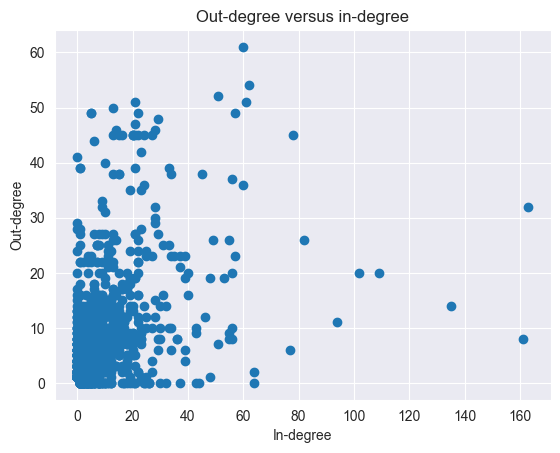

In [7]:
# Plot in- versus out-degree
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

plt.plot([val for (_, val) in G.in_degree()], [val for (_, val) in G.out_degree()], 'o')
plt.xlabel('In-degree')
plt.ylabel('Out-degree')
plt.title('Out-degree versus in-degree')
plt.show()

Most points are found on the first half of the x-axis, meaning that generally philosophers are referred to more than they refer to others. This is not surprising, since the most popular philosophers are referred to by many others, while they themselves may only refer to a few.

## Distributions of the in-degree and out-degree

In [8]:
def get_distribution(samples):
    """Accepts networkx.classes.reportviews"""
    samples = list(dict(samples).values())
    samples = Counter(samples)

    # normalize the samples to get a density distribution
    total = sum(samples.values())
    samples = {k: v / total for k, v in samples.items()}
    samples = dict(sorted(samples.items()))
    return samples

outdegrees = get_distribution(G.out_degree())
indegrees = get_distribution(G.in_degree())

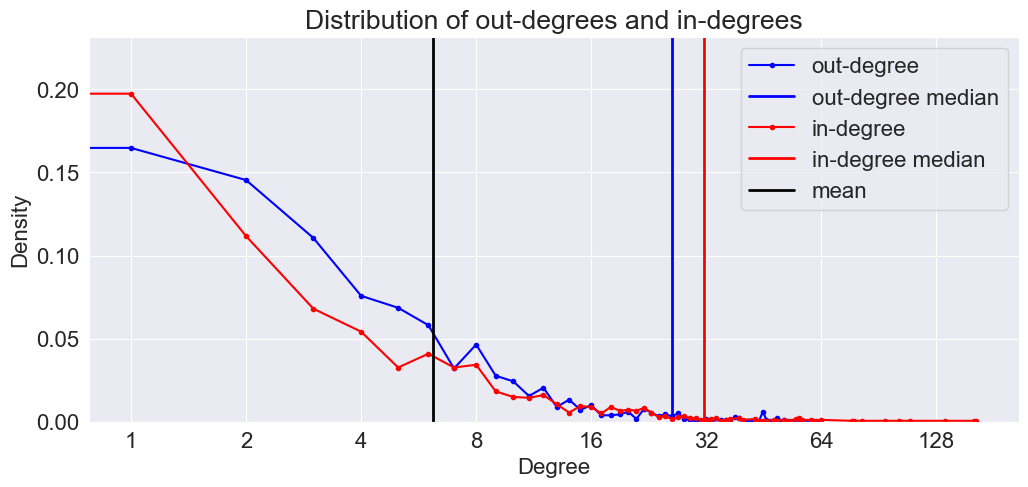

In [9]:
def plot_distribution(distributions):
    """Accets distribution as (out/in)degrees"""
    outdegrees, indegrees = distributions
    plt.rcParams["figure.figsize"] = (12, 5)
    # make all text larger
    plt.rcParams.update({'font.size': 16})
    plt.xscale('log')
    plt.plot(list(outdegrees.keys()), list(outdegrees.values()), marker='.', color='blue')
    plt.axvline(np.median(list(outdegrees.keys())), color='blue', linestyle='-', linewidth=2)  # median
    plt.plot(list(indegrees.keys()), list(indegrees.values()), marker='.', color='red')
    plt.axvline(np.median(list(indegrees.keys())), color='red', linestyle='-', linewidth=2)  # median

    plt.axvline(meanDegree / 2, color='black', linestyle='-', linewidth=2)  # mean

    ticks = [1, 2, 4, 8, 16, 32, 64, 128]
    plt.xticks(ticks, ticks)
    plt.ylim(0, max(max(outdegrees.values()), max(indegrees.values())))
    
    plt.legend(['out-degree', 'out-degree median', 'in-degree', 'in-degree median', 'mean'])
    plt.title('Distribution of out-degrees and in-degrees')
    plt.xlabel('Degree')
    plt.ylabel('Density')
    plt.show()

plot_distribution((outdegrees, indegrees))


## Top philosophers

In [10]:
from tabulate import tabulate
from operator import itemgetter

In [11]:
# First sort nodes into bins by subfield
subfield2nodes = {}
for node, data in G.nodes(data=True):
    subfield = data['subfield']
    if subfield not in subfield2nodes:
        subfield2nodes[subfield] = []
    subfield2nodes[subfield].append(node)

In [12]:
def get_top_by_degree(top, subfield=None):
    if subfield is None:
        nodes = G.nodes()
    else:
        nodes = subfield2nodes[subfield]
    degree_sequence = sorted(G.degree(nodes), key=itemgetter(1), reverse=True)[:top]
    in_degree_sequence = sorted(G.in_degree(nodes), key=itemgetter(1), reverse=True)[:top]
    out_degree_sequence = sorted(G.out_degree(nodes), key=itemgetter(1), reverse=True)[:top]

    return degree_sequence, in_degree_sequence, out_degree_sequence

def show_tabulated(top_nodes, subfield=None):
    if subfield is None:
        subfield = 'All'
    print(tabulate(top_nodes[0], headers=[f'Node    ====|{subfield}|====', 'Degree']))
    print(tabulate(top_nodes[1], headers=['Node', 'In-degree']))
    print(tabulate(top_nodes[2], headers=['Node', 'Out-degree']))
    print('\n')

print('Top 5 nodes by degree')
show_tabulated(get_top_by_degree(5))

print('Top 3 nodes by subfield')
for subfield in subfield2nodes:
    top_nodes = get_top_by_degree(3, subfield)
    show_tabulated(top_nodes, subfield)
    

Top 5 nodes by degree
Node    ====|All|====      Degree
-----------------------  --------
Aristotle                     195
Immanuel Kant                 169
Plato                         149
Bertrand Russell              129
David Hume                    123
Node                In-degree
----------------  -----------
Aristotle                 163
Immanuel Kant             161
Plato                     135
Bertrand Russell          109
Karl Marx                 102
Node                             Out-degree
-----------------------------  ------------
Friedrich Nietzsche                      61
Martin Heidegger                         54
Jacques Derrida                          52
Boethius                                 51
Georg Wilhelm Friedrich Hegel            51


Top 3 nodes by subfield
Node    ====|Humanism|====      Degree
----------------------------  --------
Albert Einstein                     64
Sigmund Freud                       64
Richard Dawkins                     62
N

In [13]:
import netwulf as nw
import math
import community as community_louvain

## Graph Visualization and Community Detection
Now it is time to visualize the graph and find communities. To do such we will now treat the graph as being undirected as this corresponds to the graph worked with in class. One could implement af directed community detection algorithm, by tweaking how the modularity is computed in the Louvan algorithm. Furthermore we are only considering the largest connected component of the graph. This is done to avoid that the algorithm finds communities in the small isolated components.

Here we set a fixed color for each subfield such that the colors are consistent across the different graphs. This is done by using a colormap.

In [14]:
# Important. Based on the 20 subfields we create a fixed color for each subfield here.
# This is to ensure the same colors are used for each subfield in the graph. 

# now lets create a dict where each subfield gets a color such that our visualizations are consistent
# lets load a color map from matplotlib
from pylab import *
cm = plt.get_cmap('gist_rainbow')
subfields = subs
# now create a dict where the keys are the subfields and the values are the colors
# we also turn them into hexadecimal strings at the same time
subfieldToColorDict = dict(zip(set(subfields), [matplotlib.colors.rgb2hex(cm(1.*i/len(set(subfields)))) for i in range(len(set(subfields)))]))
colorToSubfieldDict = dict(zip([matplotlib.colors.rgb2hex(cm(1.*i/len(set(subfields)))) for i in range(len(set(subfields)))], set(subfields)))


In [16]:
# now create the undirected graph based on the largest connected component
G = G.to_undirected()
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc)

Now we can visualize the graph where each node is colored based on its subfield.

In [17]:
# now letz visualize the graph with the soloSubfields as colors
# create a dict where the keys are the nodes and the values are the colors
nodeColorDict = dict(zip(G.nodes(), [subfieldToColorDict[G.nodes[node]["subfield"]] for node in G.nodes()]))
# we can use the nodeColorDict to color the nodes in the visualization
nx.set_node_attributes(G, nodeColorDict, name="group")

In [18]:
# visualization 
# if you want to recreate ours 
# load ourStyling from file

with open('data/graph_links_stylized_network_subfield.json') as json_file:
    graph_links_stylized_network_subfield = json.load(json_file)

# if yoy want to create your own visualization

#graph_links_stylized_network_subfield, _ = nw.visualize(G)

# if you wan to save it as well 
#with open('../data/graph_links_stylized_network_subfield.json', 'w') as fp:
#    json.dump(graph_links_stylized_network_subfield, fp)


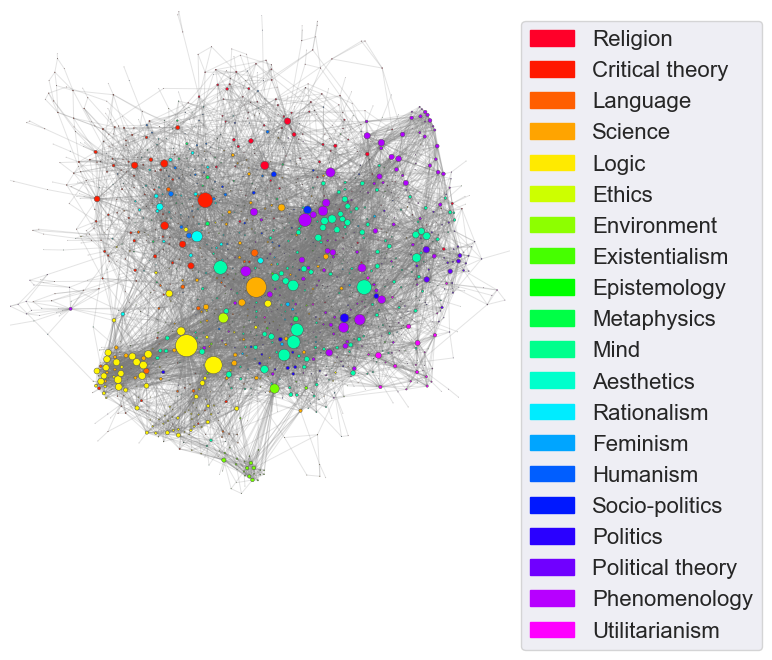

In [19]:
fig, ax = nw.draw_netwulf(graph_links_stylized_network_subfield)
# add a legend based on the subfieldToColorDict
# create legend patches as circles
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colorToSubfieldDict.keys()]
legend_labels = list(colorToSubfieldDict.values())
ax.legend(legend_patches, legend_labels, loc='upper left', bbox_to_anchor=(1, 1))
#plt.savefig('data/graph_link_subfield_network.png', dpi=300, bbox_inches='tight')
plt.show()


We see some clustering occuring. Most notably are the two big yellow nodes for Aristolte and Plato which belongs to the subfield Metaphysics. We will not go into further details before communities has been found.
To find communties we use the Louvain algorithm. This algorithm is a greedy optimization method that tries to maximize the modularity of the graph. The modularity is a measure of how well the graph is partitioned into communities. The algorithm is iterative and works by first assigning each node to its own community. Then it iterates over all nodes and tries to move it to the community that gives the largest increase in modularity. We set a random state to ensure reproducibility of the results. 

One could inspect each step of the algorithm and stop when the number of communties matches the number of subfields. We choose however to go for the maximum modularity, thus yielding in fewer communites than subfields. 

In [20]:
# lets call this graph H 
H = G.copy()
# Find all communities in the graph
# lets set fixed random state for reproducibility
random_state=123
partition = community_louvain.best_partition(H,random_state=random_state)
num_communities = len(set(partition.values()))

#again we want our colors to be consistent
# now lets create a dict where each subfield gets a color such that our visualizations are consistent
# lets load a color map from matplotlib
cm = plt.get_cmap('tab20b')
# now create a dict where the keys are the subfields and the values are the colors
# we also turn them into hexadecimal strings at the same time
groupToColorDict = dict(zip(range(0,num_communities), [matplotlib.colors.rgb2hex(cm(1.*i/num_communities)) for i in range(num_communities)]))
colorToGroupDict = dict(zip([matplotlib.colors.rgb2hex(cm(1.*i/num_communities)) for i in range(num_communities)], range(0,num_communities)))
#colorToSubfieldDict = dict(zip([matplotlib.colors.rgb2hex(cm(1.*i/len(set(subfields)))) for i in range(len(set(subfields)))], set(subfields)))


In [21]:
# Number of communities
print(f"Number of communities found: {num_communities}")
_, counts = np.unique(list((partition.values())), return_counts=True)

# Community sizes
print("\nCommunity : Count")
kek = 4
for i in range(0, len(counts), kek):
    for com, c in zip(list(range(i, i+kek)), counts[i:i+kek]):
        print(f"{com} : {c} ", end="| ")
    print()

# Modularity
modularity = community_louvain.modularity(partition, H)
print(f"\nThe modularity of the graph is: {modularity}")

Number of communities found: 11

Community : Count
0 : 421 | 1 : 289 | 2 : 148 | 3 : 93 | 
4 : 47 | 5 : 51 | 6 : 247 | 7 : 225 | 
8 : 187 | 9 : 76 | 10 : 6 | 

The modularity of the graph is: 0.5432382102751409


The algorithm finds 11 communities with varying sizes. We have community 10 as the smallest. It only includes 6 nodes, compared to the largest community 0 which includes 421 nodes. 
The modularity of the graph is 0.55 and indicates that the number of edges within communties are larger than they would be by chance.

In [22]:
# set the attributes of the nodes to the community they belong to
nx.set_node_attributes(H, partition, name="group")
# map group to color
nodeColorDict = dict(zip(H.nodes(), [groupToColorDict[H.nodes[node]["group"]] for node in H.nodes()]))
# we can use the nodeColorDict to color the nodes in the visualization
nx.set_node_attributes(H, nodeColorDict, name="group")

Visualization of communities

In [25]:
# visualization 
# if you want to recreate ours 
# load ourStyling from file
with open('data/graph_links_stylized_network_groups.json') as json_file:
   stylized_network_groups = json.load(json_file)

# if yoy want to create your own visualization
#stylized_network_groups, _ = nw.visualize(H)
# if you wan to save it as well 
#with open('../data/graph_links_stylized_network_groups', 'w') as fp:
#    json.dump(stylized_network_groups, fp)

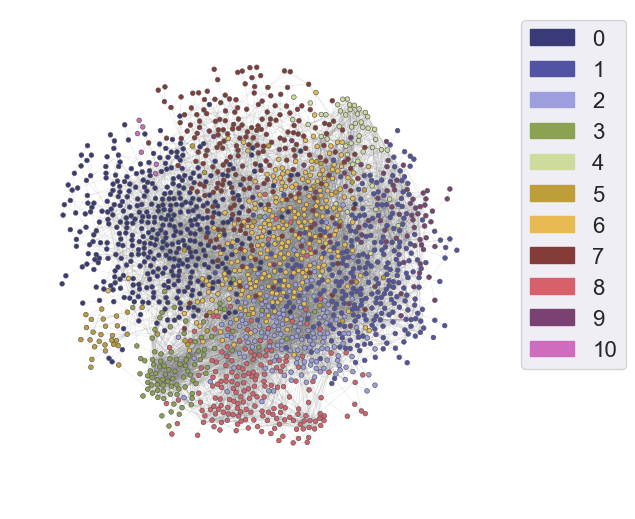

In [26]:
fig, ax = nw.draw_netwulf(stylized_network_groups)
# add a legend based on the subfieldToColorDict
# create legend patches as circles
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colorToGroupDict.keys()]
legend_labels = list(colorToGroupDict.values())
ax.legend(legend_patches, legend_labels, loc='upper left', bbox_to_anchor=(1, 1))
#plt.savefig('data/graph_link_group_network.png', dpi=300, bbox_inches='tight')
plt.show()

## Wordclouds for each community
We will now create and inspect the wordclouds for each community to get an idea of what the communities are about. We also inspect the top 3 subfields in each community. 

We start by finding the philosophers that are in the largest connected component.

In [27]:
# lets make some wordclouds for the communities found
nodesIngraph = list(H.nodes())
# mask the df by the nodes in the graph
df = df[df['label'].isin(nodesIngraph)]

To calculate the TF-IDF scores for each community we create a large document for each community containing all the tokenized summaries of the philosophers in that community.

In [28]:
# we will need a range over the communities
communityRange = range(0,num_communities)
# create a dictionary where the keys are the communities and the values are the tokens
documentDict = {community:[] for community in communityRange}
# unique values for the communities
for community in range(0,num_communities):
    # filter the df based on community
    labels = [key for key,value in partition.items() if value == community]
    communityDF = df[df['label'].isin(labels)]
    # add the tokens to the dictionary
    documentDict[community].extend([item for sublist in communityDF["tokens"] for item in sublist])    


We are also interested in top 3 subfield, top 3 gender and top 3 country for each community

In [50]:

communitySubfieldDict = {}
communityGenderDict ={}
communityCountryDict ={}

for community in range(0,num_communities):
    # filter the graph based on subfield
    labels = [key for key,value in partition.items() if value == community]    
    communityGraph = H.subgraph(labels)
    # get the subfields of the nodes in the subgraph
    subfields = Counter([communityGraph.nodes[node]["subfield"] for node in communityGraph.nodes()])
    # get the top 3 subfields
    communitySubfieldDict[community]=subfields

    # get the gender of the nodes in the subgraph
    gender = Counter([communityGraph.nodes[node]["sex"] for node in communityGraph.nodes()])
    # get the top 3 genders
    communityGenderDict[community]=gender

    # get the country of the nodes in the subgraph
    country = Counter([communityGraph.nodes[node]["country"] for node in communityGraph.nodes()])
    # get the top 3 countries
    communityCountryDict[community]=country

Now we are ready to calculate the TF-IDF in each community

In [51]:
# make a dictionary containing counter objects for each community document
counterDocumentsDict = {community: Counter(documentDict[community]) for community in communityRange}

# redefine unique tokens to only be the tokens in the documents found in the current graph. 
uniqueTokens = list(set([item for sublist in documentDict.values() for item in sublist]))

# we start by calculating the IDF for each word/token# 
N = len(documentDict)
IDF_dict = {token: math.log2(N/sum([1 for documentCounter in counterDocumentsDict.values() if documentCounter[token] !=0 ])) for token in uniqueTokens} 

# Calculate the TF and TF-IDF for each community
TF_dict = {token: {community: 0 for community in communityRange} for token in uniqueTokens}
TF_IDF_dict = {token: {community: 0 for community in communityRange} for token in uniqueTokens}

for community in communityRange:    
    document = counterDocumentsDict[community]
    documentLen = len(documentDict[community])    
    for token in uniqueTokens:
        TF_dict[token][community] = document[token]/documentLen
        TF_IDF_dict[token][community] = TF_dict[token][community]*IDF_dict[token]

# swap such that we have subfield as key and dictionary with tokens as keys as values
communitydFreqDict = {community: {token: TF_IDF_dict[token][community] for token in uniqueTokens} for community in communityRange}



Using the TF-IDF scores we can now create the wordclouds for each community

In [52]:
# lets plot the wordclouds for each community
from wordcloud import WordCloud

def create_wordclouds(communitydFreqDict):
    clouds=[]
    for i, community in enumerate(communityRange):
        # i know that i and community are the same, but it is code that is taken from the worcloud for subfields
        wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(communitydFreqDict[community])
        clouds.append(wordcloud)
    return clouds

# create the wordclouds
clouds = create_wordclouds(communitydFreqDict)
# 45s

Here we visualize alle the wordclouds in one figure but we suggest going to the next block where one can choose one community at a time. This is also here some analysis of each community / wordcloud is done. 

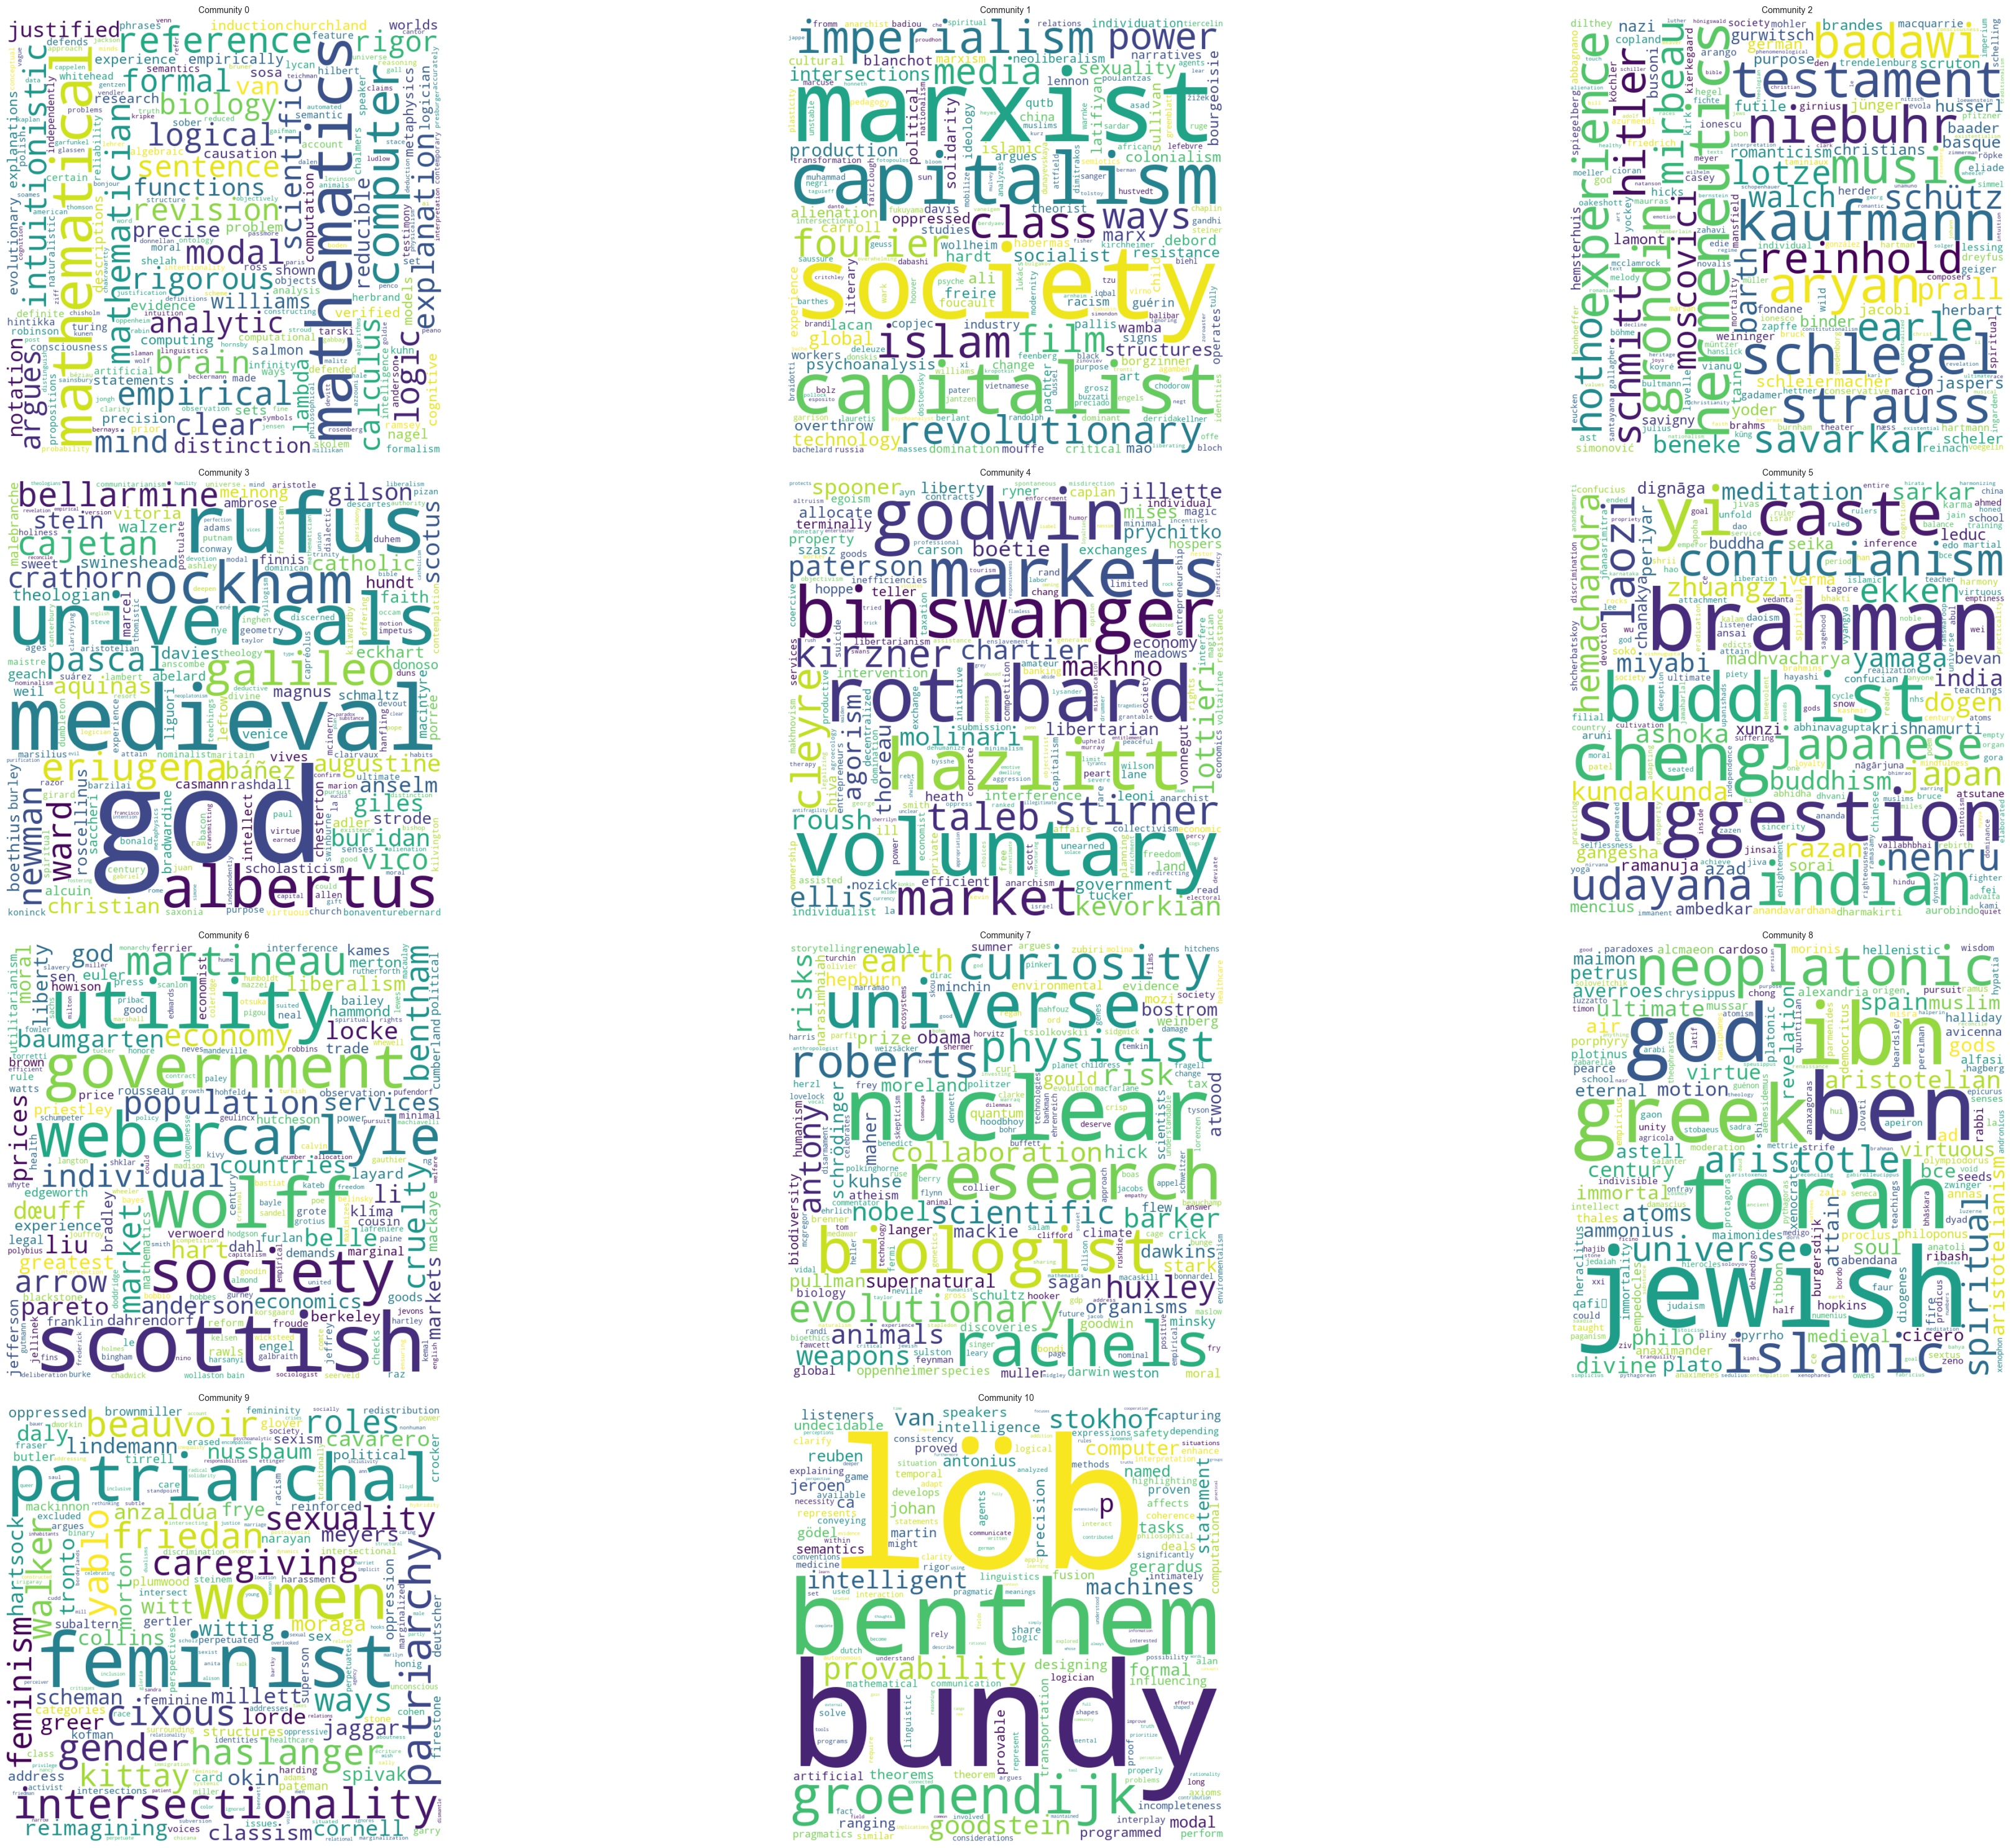

In [53]:
# lets plot the wordclouds for each community
def plot_wordclouds(wordclouds, communityRange, plotName: str):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(40, 30))
    #fig, axes = plt.subplots(nrows=4, ncols=3)
    axes = axes.flatten()
    # iterate over each list of words and create a wordcloud for it
    for i, community in enumerate(communityRange):
        
        wordcloud = wordclouds[i]        
        # plot the wordcloud in the i-th subplot
        axes[i].imshow(wordcloud, interpolation="bilinear")
        #
        axes[i].axis('off')
        axes[i].set_title(f"Community {community}", fontsize=30)        
    # remove the last axes 
    fig.delaxes(axes[-1])

    #plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.tight_layout()
    #plt.savefig('data\graph_links_wordclouds_' + plotName +'.png', dpi=300)
    # plt.close()

plot_wordclouds(clouds, communityRange, "subfield")

In [60]:
# define function for one wordcloud at a time
def plot_single_wordcloud(wordclouds, relevantDict, community):
    wordcloud = wordclouds[i]    
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"Community {community} \n  {relevantDict[community].most_common(3)}", fontsize=10)
    plt.tight_layout()
    #plt.savefig(f'data\wordcloud{community}', dpi=300)
    # plt.close()

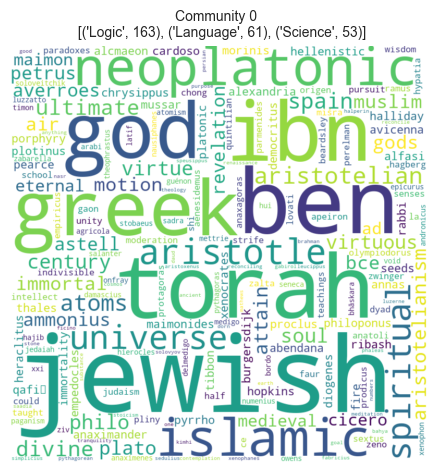

In [64]:
plot_single_wordcloud(clouds, communitySubfieldDict, 0)   

### Community 0
Explanation of each worcloud here